In [1]:
import tensorflow as tf 
from tensorflow import keras
import numpy as np
import os
import time
from pathlib import Path
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import math

In [2]:
DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/quickdraw",
                                extract=True)

In [3]:
quickdraw_dir = Path(filepath).parent
train_files = sorted([str(path) for path in quickdraw_dir.glob("training.tfrecord-*")])
eval_files = sorted([str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")])

with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()
    
with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

# sorted(class_names)

In [4]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

def quickdraw_dataset(filepaths, batch_size=128, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    AUTOTUNE = tf.data.AUTOTUNE
    return dataset.prefetch(AUTOTUNE)

In [5]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

for sketches, lengths, labels in train_set.take(1):
    print("sketches =", sketches)
    print("lengths =", lengths)
    print("labels =", labels)

sketches = tf.Tensor(
[[[-0.04705882 -0.26771653  0.        ]
  [ 0.10196079  0.13385828  1.        ]
  [-0.05882353  0.13385826  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[-0.00392157  0.125       0.        ]
  [ 0.01176471  0.04807693  0.        ]
  [ 0.04705882  0.03846154  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.04954955 -0.02745098  0.        ]
  [ 0.3108108  -0.05882353  0.        ]
  [ 0.4279279  -0.06274511  1.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[ 0.03137255  0.          0.        ]
  [ 0.03137255  0.02238807  0.        ]
  [ 0.14509806  0.26119402  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

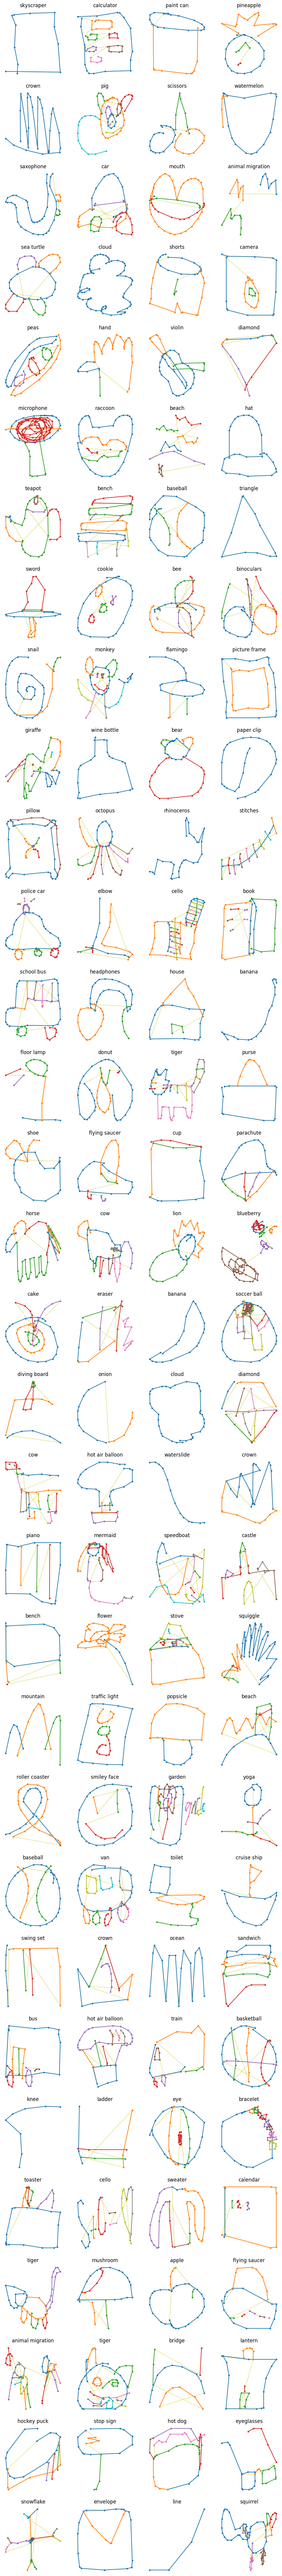

In [6]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = np.cumsum(sketch[:, :2], axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

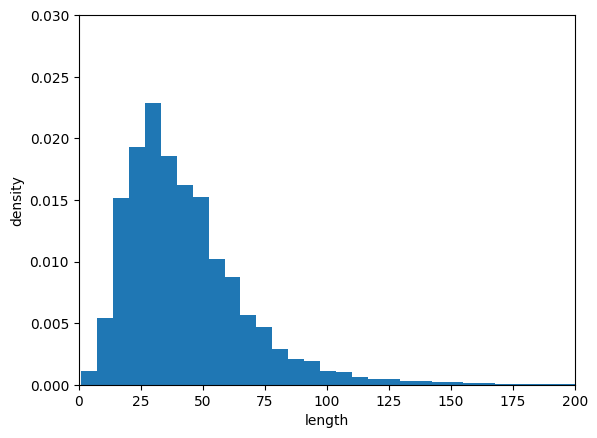

In [7]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()

In [8]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [9]:
model = keras.models.Sequential([
    keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(len(class_names), activation="softmax")
])

optimizer = keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9,
                                nesterov=True, weight_decay=0.001)

In [10]:
def get_run_logdir():
    root_logdir = os.path.join(os.curdir, "my_logs")
    run_id = time.strftime("run_%Y_%m_%d-%H_%M")
    return os.path.join(root_logdir, run_id)

In [11]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=1)
tensorboard_cb = keras.callbacks.TensorBoard(get_run_logdir())

model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, 
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])

In [12]:
history = model.fit(cropped_train_set, epochs=10, validation_data=cropped_valid_set,
                    callbacks=[early_stopping_cb, lr_scheduler, tensorboard_cb])

model.save("my_sketch_rnn_model.keras")

Epoch 1/10
  26954/Unknown 1237s 46ms/step - accuracy: 0.1991 - loss: 3.9650 - sparse_top_k_categorical_accuracy: 0.3944

C:\Users\48503\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


26954/26954 ━━━━━━━━━━━━━━━━━━━━ 1272s 47ms/step - accuracy: 0.1991 - loss: 3.9650 - sparse_top_k_categorical_accuracy: 0.3944 - val_accuracy: 0.4619 - val_loss: 2.2565 - val_sparse_top_k_categorical_accuracy: 0.7513 - learning_rate: 0.0100
Epoch 2/10
26954/26954 ━━━━━━━━━━━━━━━━━━━━ 16562s 614ms/step - accuracy: 0.5131 - loss: 2.0253 - sparse_top_k_categorical_accuracy: 0.7894 - val_accuracy: 0.5470 - val_loss: 1.8583 - val_sparse_top_k_categorical_accuracy: 0.8160 - learning_rate: 0.0100
Epoch 3/10
26954/26954 ━━━━━━━━━━━━━━━━━━━━ 1172s 43ms/step - accuracy: 0.5623 - loss: 1.7908 - sparse_top_k_categorical_accuracy: 0.8253 - val_accuracy: 0.5666 - val_loss: 1.7692 - val_sparse_top_k_categorical_accuracy: 0.8284 - learning_rate: 0.0100
Epoch 4/10
26954/26954 ━━━━━━━━━━━━━━━━━━━━ 1389s 52ms/step - accuracy: 0.5844 - loss: 1.6908 - sparse_top_k_categorical_accuracy: 0.8399 - val_accuracy: 0.5477 - val_loss: 1.8403 - val_sparse_top_k_categorical_accuracy: 0.8193 - learning_rate: 0.0100
E

C:\Users\48503\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


The mean top-5 accuracy: 0.51
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step 


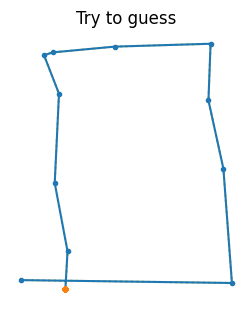

Top-5 predictions:
  1. skyscraper 44.543%
  2. diving board 11.075%
  3. crayon 5.834%
  4. door 4.790%
  5. pencil 2.950%
Answer: skyscraper


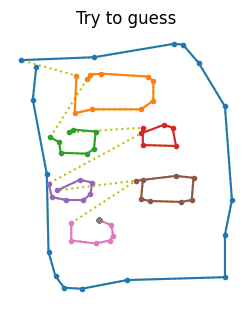

Top-5 predictions:
  1. remote control 66.597%
  2. cell phone 14.669%
  3. calculator 7.876%
  4. skyscraper 4.093%
  5. telephone 3.074%
Answer: calculator


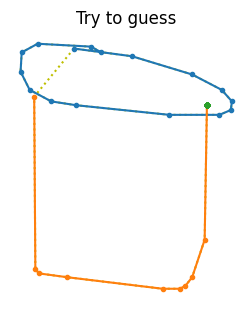

Top-5 predictions:
  1. cup 55.092%
  2. paint can 13.026%
  3. mug 8.094%
  4. microphone 4.881%
  5. bread 2.744%
Answer: paint can


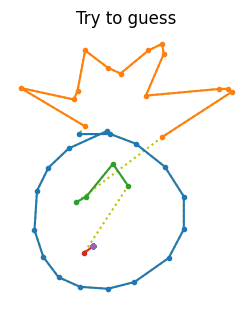

Top-5 predictions:
  1. pineapple 85.148%
  2. carrot 5.074%
  3. strawberry 3.840%
  4. blueberry 1.223%
  5. onion 1.019%
Answer: pineapple


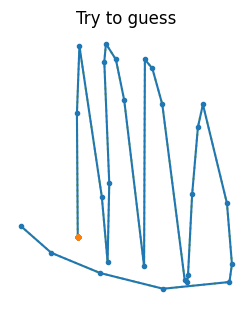

Top-5 predictions:
  1. toothbrush 54.106%
  2. grass 10.803%
  3. bridge 6.461%
  4. crown 5.684%
  5. the great wall of china 3.383%
Answer: crown


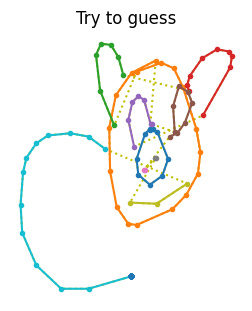

Top-5 predictions:
  1. mouse 55.444%
  2. pig 19.217%
  3. bear 4.300%
  4. monkey 3.852%
  5. cat 2.479%
Answer: pig


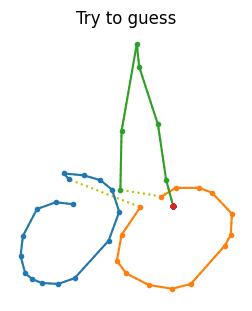

Top-5 predictions:
  1. mosquito 44.125%
  2. scissors 13.508%
  3. blueberry 10.887%
  4. mouse 2.793%
  5. hat 2.742%
Answer: scissors


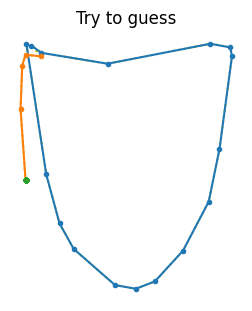

Top-5 predictions:
  1. canoe 44.455%
  2. watermelon 27.428%
  3. bathtub 7.147%
  4. underwear 5.796%
  5. cup 2.761%
Answer: watermelon


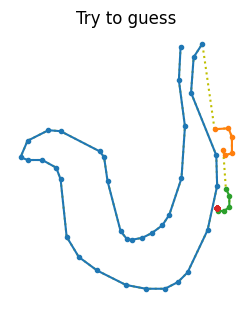

Top-5 predictions:
  1. saxophone 97.110%
  2. snorkel 0.427%
  3. snake 0.350%
  4. toe 0.268%
  5. stethoscope 0.254%
Answer: saxophone


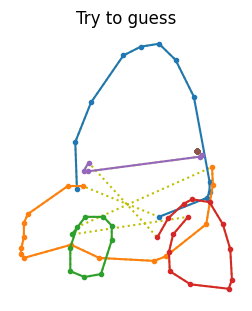

Top-5 predictions:
  1. car 70.430%
  2. police car 10.190%
  3. pickup truck 7.105%
  4. sea turtle 2.888%
  5. truck 2.248%
Answer: car


In [15]:
model = keras.models.load_model("my_sketch_rnn_model.keras")

y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set, verbose=0)

mean_acc = np.mean(keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))
print(f"The mean top-5 accuracy: {mean_acc:.2f}")

n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print("Top-5 predictions:".format(index + 1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print("  {}. {} {:.3f}%".format(k + 1, class_name, proba))
    print("Answer: {}".format(class_names[labels[index].numpy()]))
